In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns
# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

## Incentive Schemes for Georges  Protocol

In [2]:
d = df[df.protocol == "george"]

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

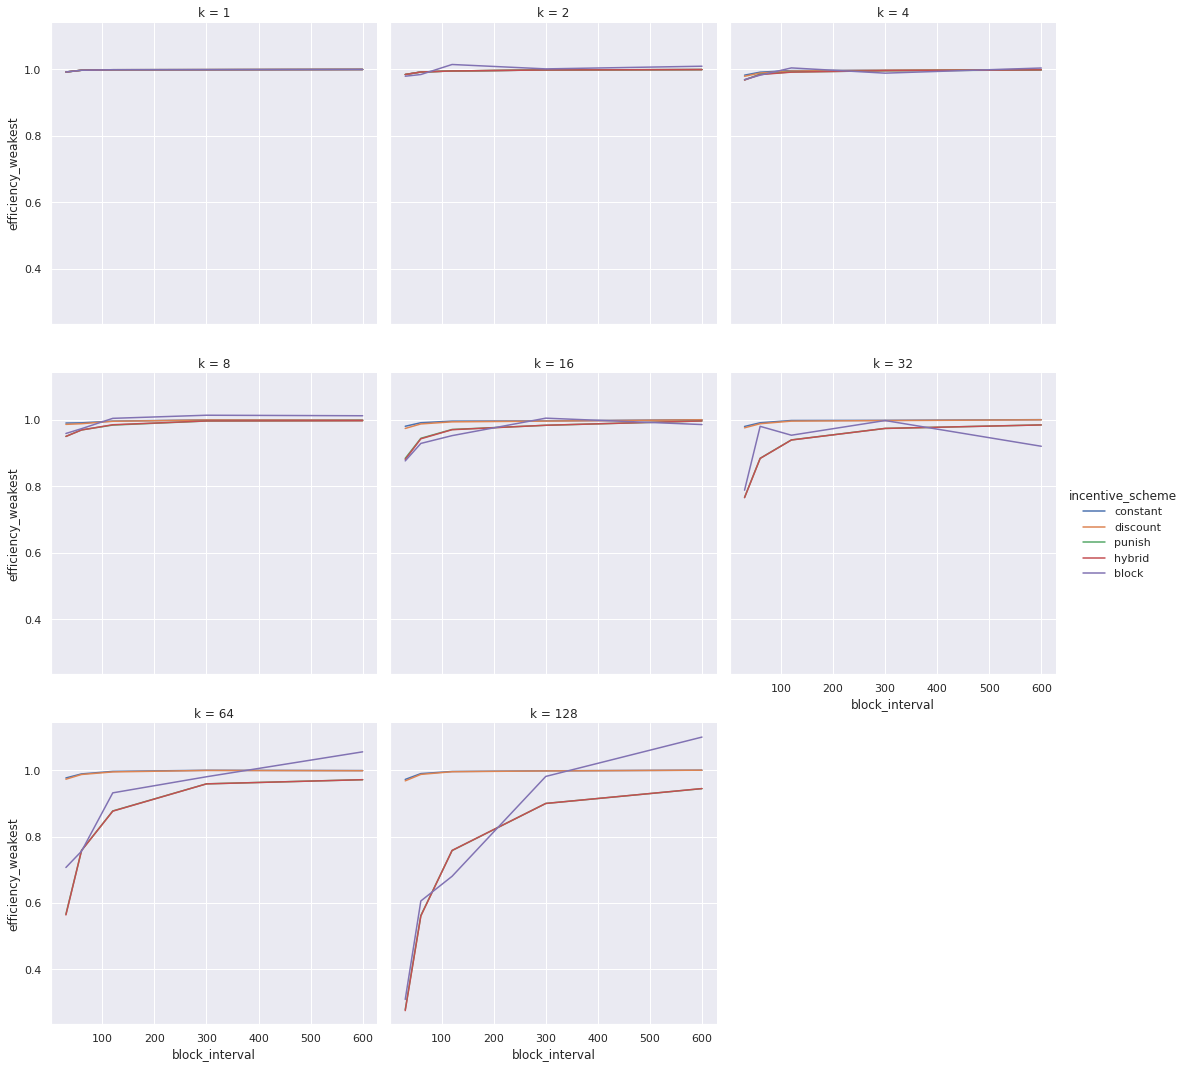

In [3]:
sns.relplot(
    data=d,
    x="block_interval", y="efficiency_weakest", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

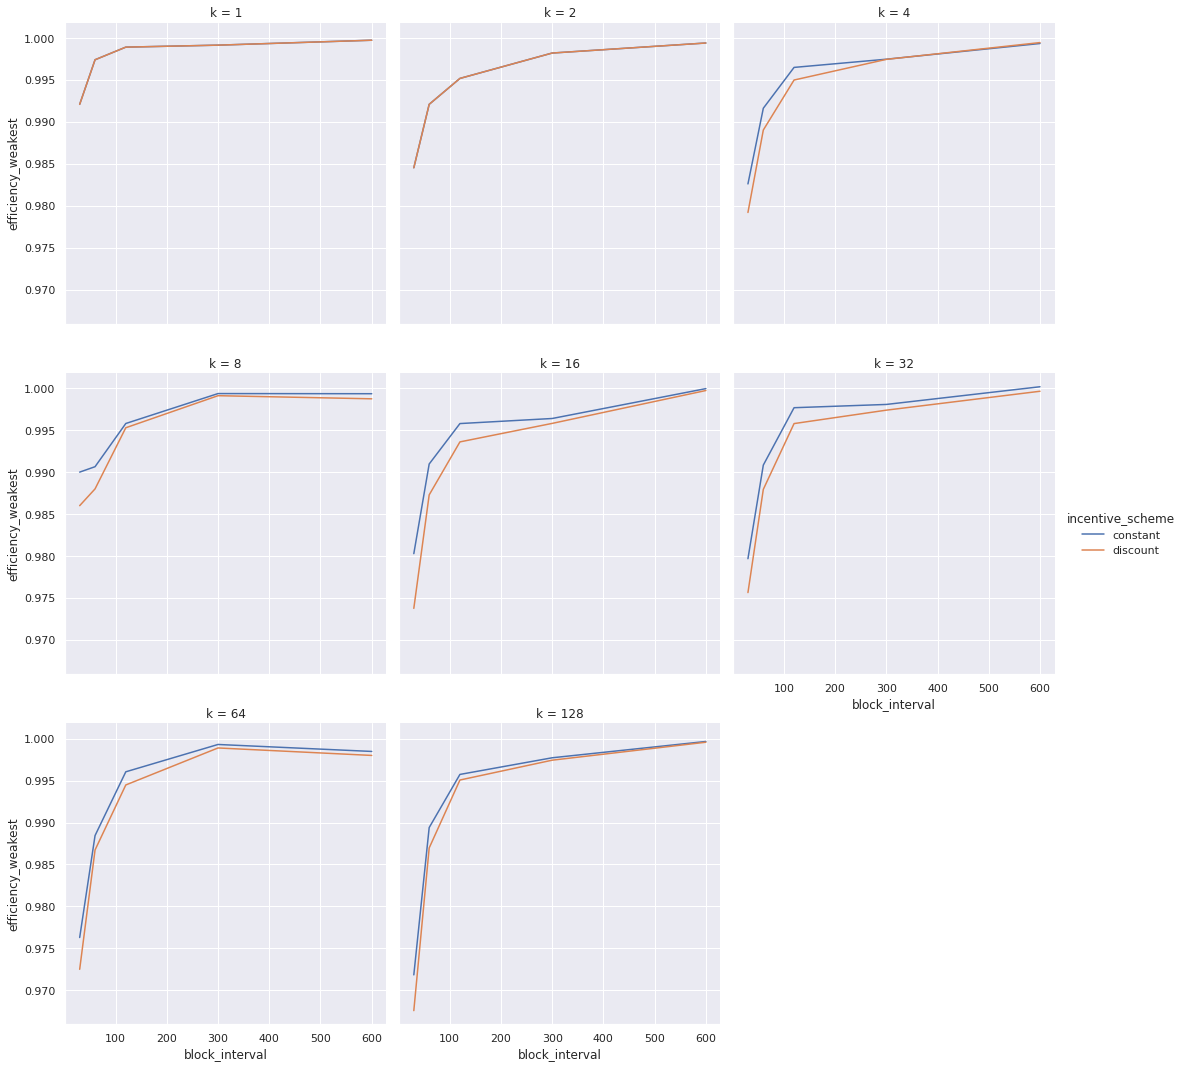

In [4]:
sns.relplot(
    data=d[(d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")],
    x="block_interval", y="efficiency_weakest", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

In [5]:
eff = d.rename(
    columns={'incentive_scheme': 'Incentive Scheme',
            'block_interval': 'Block Interval'}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme       block  constant  discount    hybrid    punish
Block Interval k                                                    
30.0           1    0.992089  0.992089  0.992089  0.992089  0.992089
               2    0.979370  0.984524  0.984524  0.984524  0.984524
               4    0.969144  0.982597  0.979192  0.968015  0.968317
               8    0.958619  0.990011  0.986010  0.949719  0.949744
               16   0.876111  0.980285  0.973759  0.880527  0.883656
               32   0.787942  0.979684  0.975643  0.765495  0.766121
               64   0.706918  0.976288  0.972495  0.564144  0.566400
               128  0.309871  0.971832  0.967567  0.276268  0.278929
60.0           1    0.997408  0.997408  0.997408  0.997408  0.997408
               2    0.984510  0.992090  0.992090  0.992090  0.992090
               4    0.982581  0.991625  0.989028  0.984381  0.985651
               8    0.973052  0.990658  0.988010  0.969158  0.969362
               16   0.928676  0.990979  0.987295  0.942620  0.944108
               32   0.980084  0.990850  0.987956  0.883501  0.883934
               64   0.755855  0.988448  0.986730  0.757980  0.758176
               128  0.606197  0.989402  0.986972  0.561118  0.562406
120.0          1    0.998914  0.998914  0.998914  0.998914  0.998914
               2    1.014695  0.995182  0.995182  0.995182  0.995182
               4    1.004402  0.996496  0.994990  0.991689  0.992175
               8    1.004145  0.995811  0.995303  0.984850  0.983895
               16   0.952122  0.995802  0.993615  0.969972  0.970667
               32   0.953373  0.997694  0.995801  0.938959  0.939303
               64   0.931440  0.996054  0.994484  0.876403  0.876978
               128  0.680415  0.995741  0.995073  0.758178  0.757881
300.0          1    0.999150  0.999150  0.999150  0.999150  0.999150
               2    1.001489  0.998209  0.998209  0.998209  0.998209
               4    0.988634  0.997473  0.997453  0.996140  0.995720
               8    1.013500  0.999380  0.999127  0.996325  0.996137
               16   1.004682  0.996407  0.995822  0.983355  0.983204
               32   0.997522  0.998083  0.997401  0.973801  0.973846
               64   0.979873  0.999314  0.998898  0.958439  0.958555
               128  0.980890  0.997727  0.997439  0.899535  0.899606
600.0          1    0.999739  0.999739  0.999739  0.999739  0.999739
               2    1.009494  0.999407  0.999407  0.999407  0.999407
               4    1.004113  0.999346  0.999459  0.998562  0.998153
               8    1.011927  0.999362  0.998755  0.996917  0.997235
               16   0.985443  0.999971  0.999744  0.996317  0.996318
               32   0.920141  1.000195  0.999657  0.984289  0.984406
               64   1.054857  0.998483  0.998007  0.971018  0.971085
               128  1.099209  0.999671  0.999583  0.944330  0.944105

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [6]:
d.compute_gini.unique()

array([0.3])

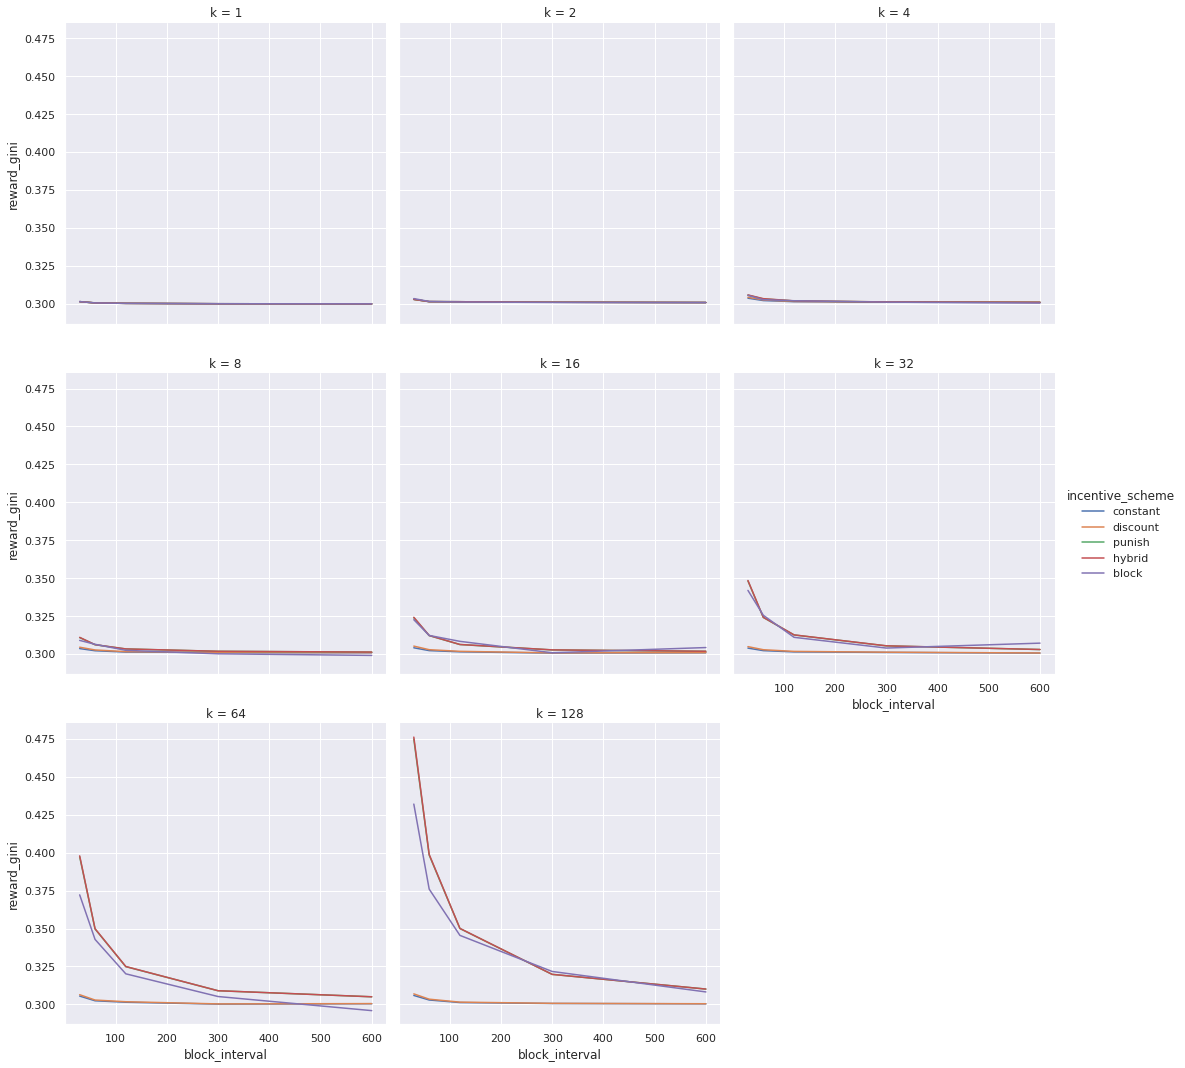

In [7]:
sns.relplot(
    data=d,
    x="block_interval", y="reward_gini", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

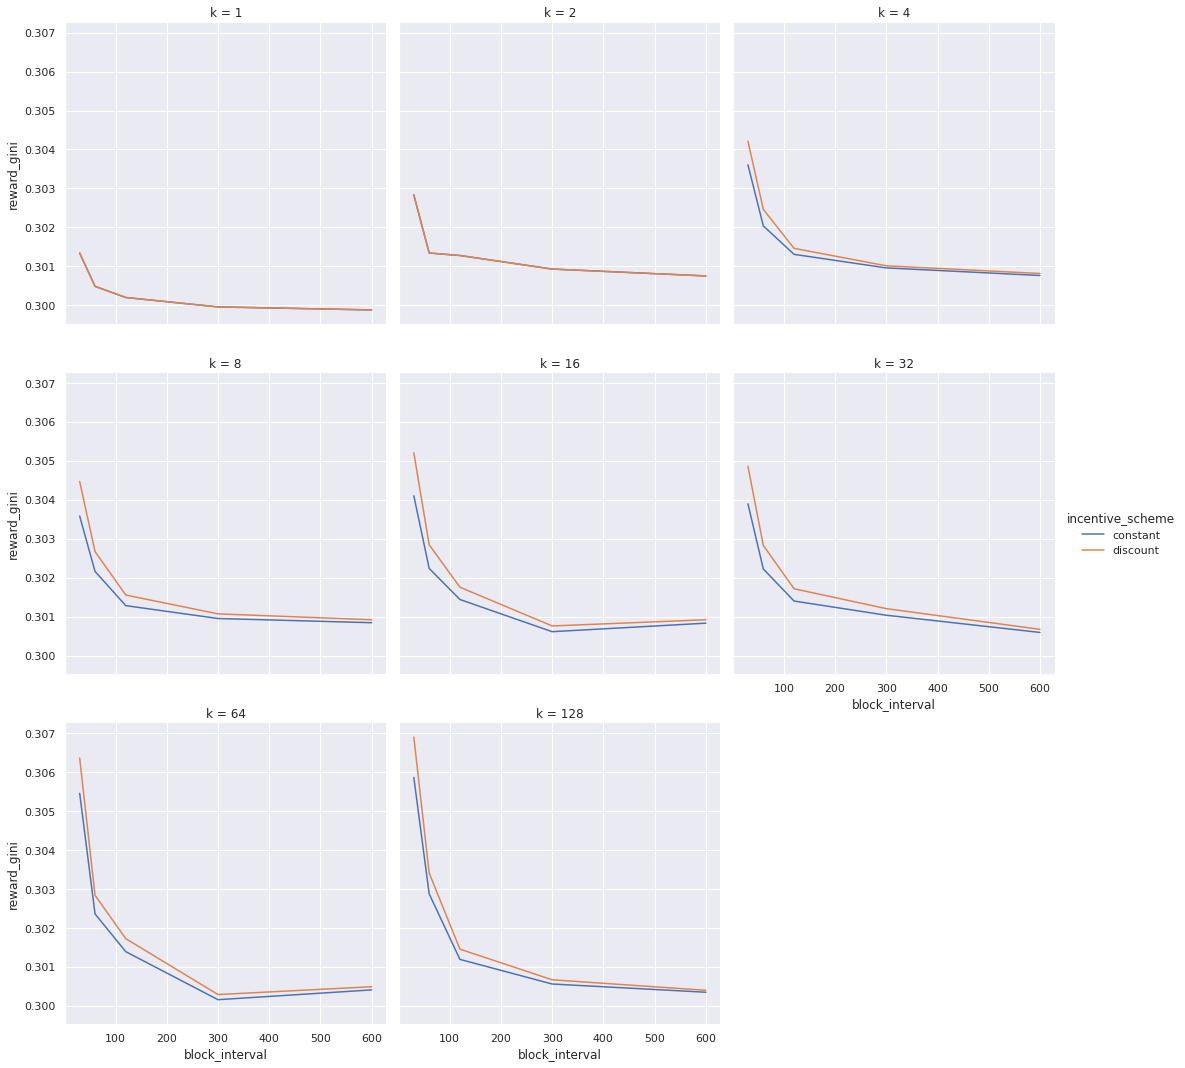

In [8]:
sns.relplot(
    data=d[(d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")],
    x="block_interval", y="reward_gini", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

In [9]:
gini = d.rename(
    columns={'incentive_scheme': 'Incentive Scheme',
            'block_interval': 'Block Interval'}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme       block  constant  discount    hybrid    punish
Block Interval k                                                    
30.0           1    0.301341  0.301341  0.301341  0.301341  0.301341
               2    0.303348  0.302833  0.302833  0.302833  0.302833
               4    0.305474  0.303605  0.304212  0.305758  0.305595
               8    0.308975  0.303581  0.304472  0.310971  0.310823
               16   0.322615  0.304104  0.305211  0.324210  0.323930
               32   0.341937  0.303897  0.304863  0.348468  0.348164
               64   0.372177  0.305460  0.306365  0.397904  0.397305
               128  0.432037  0.305869  0.306905  0.476211  0.474919
60.0           1    0.300484  0.300484  0.300484  0.300484  0.300484
               2    0.301437  0.301341  0.301341  0.301341  0.301341
               4    0.302621  0.302038  0.302462  0.303290  0.303116
               8    0.306401  0.302161  0.302670  0.306168  0.306102
               16   0.312242  0.302239  0.302846  0.312219  0.312138
               32   0.325534  0.302224  0.302829  0.324198  0.324101
               64   0.342819  0.302362  0.302841  0.349864  0.349705
               128  0.375986  0.302878  0.303412  0.398846  0.398428
120.0          1    0.300198  0.300198  0.300198  0.300198  0.300198
               2    0.301106  0.301277  0.301277  0.301277  0.301277
               4    0.301921  0.301307  0.301461  0.301842  0.301811
               8    0.302409  0.301282  0.301555  0.303354  0.303328
               16   0.308348  0.301440  0.301756  0.306289  0.306231
               32   0.311002  0.301401  0.301716  0.312601  0.312561
               64   0.320127  0.301393  0.301727  0.324945  0.324858
               128  0.345470  0.301195  0.301458  0.350068  0.349984
300.0          1    0.299957  0.299957  0.299957  0.299957  0.299957
               2    0.300812  0.300929  0.300929  0.300929  0.300929
               4    0.301003  0.300958  0.301013  0.301146  0.301136
               8    0.300130  0.300952  0.301071  0.301801  0.301784
               16   0.300827  0.300614  0.300761  0.302722  0.302694
               32   0.303927  0.301036  0.301206  0.305404  0.305367
               64   0.305163  0.300160  0.300292  0.308991  0.308979
               128  0.321687  0.300563  0.300671  0.319781  0.319759
600.0          1    0.299879  0.299879  0.299879  0.299879  0.299879
               2    0.300703  0.300752  0.300752  0.300752  0.300752
               4    0.300425  0.300764  0.300815  0.300915  0.300897
               8    0.299081  0.300844  0.300920  0.301272  0.301246
               16   0.304252  0.300832  0.300920  0.301809  0.301780
               32   0.307163  0.300594  0.300674  0.302966  0.302950
               64   0.295866  0.300412  0.300493  0.304998  0.304981
               128  0.308191  0.300351  0.300401  0.310069  0.310088